In [1]:
!pip install numpy pandas librosa soundfile scikit-learn matplotlib seaborn joblib tqdm


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
!pip install sounddevice scipy pyaudio


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
!pip install librosa


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
!pip install pydub


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
!ffmpeg -version


ffmpeg version 2025-03-31-git-35c091f4b7-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
built with gcc 14.2.0 (Rev1, Built by MSYS2 project)
configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-lcms2 --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-libdvdnav --enable-libdvdread --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-libqrencode --enable-librav1e --enable-libsvtav1 --enable-libvvenc --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libvpx --e

## Imports

In [4]:
import os
import glob
import random
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns

from pydub import AudioSegment
from pydub.playback import play

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



## Play random audios, extract features and plot

In [5]:
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    mfccs = np.mean(mfccs.T, axis=0)
    chroma = np.mean(chroma.T, axis=0)
    spectral_contrast = np.mean(spectral_contrast.T, axis=0)
    return np.hstack([mfccs, chroma, spectral_contrast])


def plot_features(features, title):
    mfccs = features[:13]
    chroma = features[13:25]
    spectral_contrast = features[25:]
    plt.figure(figsize=(10, 4))
    
    plt.subplot(3, 1, 1)
    plt.plot(mfccs,)
    plt.title(f'MFCCs for {title}')
    plt.xlabel('Coefficients')
    plt.ylabel('Amplitude')
    
    plt.subplot(3, 1, 2)
    plt.plot(chroma)
    plt.title(f'Chroma for {title}')
    plt.xlabel('Chroma Bins')
    plt.ylabel('Amplitude')
    
    plt.subplot(3, 1, 3)
    plt.plot(spectral_contrast)
    plt.title(f'Spectral Contrast for {title}')
    plt.xlabel('Frequency Bands')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

Playing and extracting features for Female Audios
Playing: C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_angry\YAF_team_angry.wav


C:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


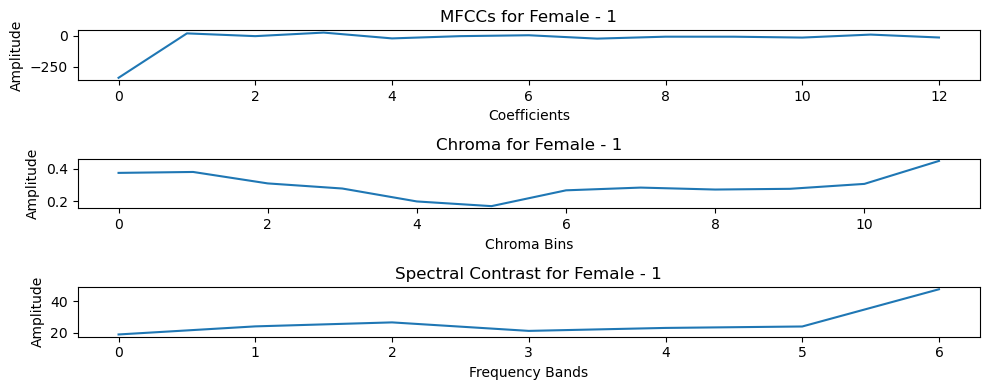

Playing: C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_sad\YAF_limb_sad.wav


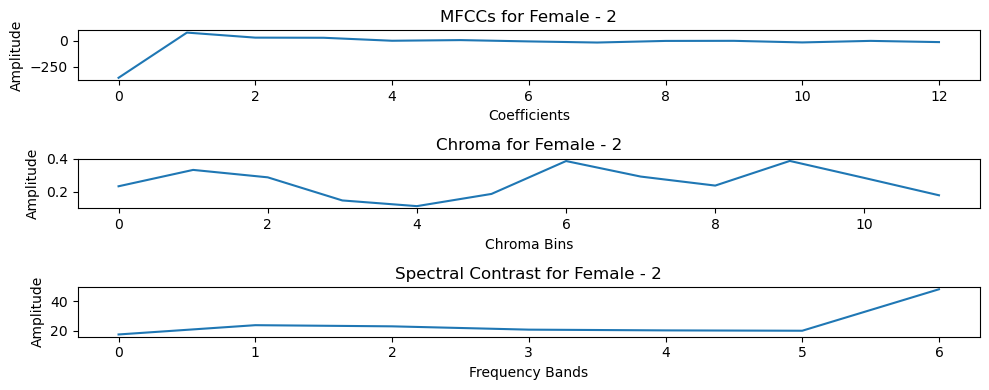

Playing and extracting features for Male Audios
Playing: C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Male\OAF_angry\OAF_hurl_angry.wav


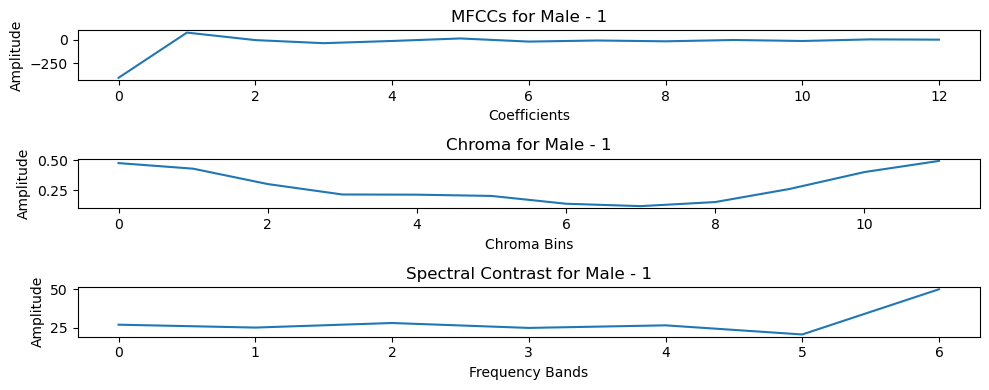

Playing: C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Male\OAF_Fear\OAF_hash_fear.wav


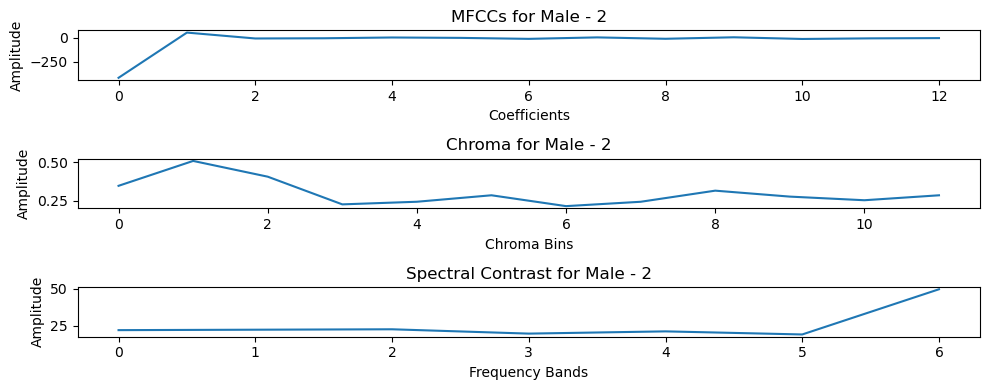

In [6]:
female_audios = glob.glob('C:\\Users\\Lutifah\\Desktop\\Speech-emotion-detection-main\\TESS\\Female\\**\\**', recursive=True)
male_audios = glob.glob('C:\\Users\\Lutifah\\Desktop\\Speech-emotion-detection-main\\TESS\\Male\\**\\**', recursive=True)


print('Playing and extracting features for Female Audios')
for i in range(2):
    female_audio = random.choice(female_audios)
    print(f"Playing: {female_audio}")
    sound = AudioSegment.from_file(female_audio)
    play(sound)
    
    features = extract_features(female_audio)
    plot_features(features, title=f'Female - {i+1}')

print('Playing and extracting features for Male Audios')
for i in range(2):
    male_audio = random.choice(male_audios)
    print(f"Playing: {male_audio}")
    sound = AudioSegment.from_file(male_audio)
    play(sound)
    
    features = extract_features(male_audio)
    plot_features(features, title=f'Male - {i+1}')


## Preparing dataset

In [7]:
import glob
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

# Collect audio file paths
female_audios = glob.glob(r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\**\*.wav', recursive=True)
male_audios = glob.glob(r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Male\**\*.wav', recursive=True)

print(f"Found {len(female_audios)} female audio files.")
print(f"Found {len(male_audios)} male audio files.")

def prepare_dataset(audio_files, gender_label):
    """
    Extract features from a list of audio files and assign the given gender label.

    Parameters:
        audio_files (list): List of paths to audio files (.wav)
        gender_label (int): Label for gender (0 = Female, 1 = Male)

    Returns:
        pd.DataFrame: DataFrame of extracted features
        list: Corresponding gender labels
    """
    features = []
    for file_path in audio_files:
        try:
            feature_vector = extract_features(file_path)
            features.append(feature_vector)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    return pd.DataFrame(features), [gender_label] * len(features)

# Prepare gender classification dataset (0 = Female, 1 = Male)
female_features, female_labels = prepare_dataset(female_audios, 0)
male_features, male_labels = prepare_dataset(male_audios, 1)

# Combine both datasets
X_gender = pd.concat([female_features, male_features], ignore_index=True)
y_gender = np.array(female_labels + male_labels)

# Shuffle the dataset to prevent order bias
X_gender, y_gender = shuffle(X_gender, y_gender, random_state=42)

# Print dataset shape for confirmation
print(f"Feature dataset shape: {X_gender.shape}")
print(f"Labels shape: {y_gender.shape}")


Found 1400 female audio files.
Found 1400 male audio files.
Feature dataset shape: (2800, 32)
Labels shape: (2800,)


## Splitting dataset & Training gender model

In [8]:
import os
import numpy as np
import librosa

def extract_features(directory, label):
    features = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            filepath = os.path.join(directory, filename)
            audio, sr = librosa.load(filepath, sr=None)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=32)
            mfccs_processed = np.mean(mfccs.T, axis=0)
            features.append(mfccs_processed)
            labels.append(label)
    return features, labels

female_path = r"C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_angry"
male_path = r"C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Male\OAF_angry"

female_features, female_labels = extract_features(female_path, 0)
male_features, male_labels = extract_features(male_path, 1)

features = np.array(female_features + male_features)
labels = np.array(female_labels + male_labels)

print(f"Feature dataset shape: {features.shape}")
print(f"Labels shape: {labels.shape}")


Feature dataset shape: (400, 32)
Labels shape: (400,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


## Evaluating gender model

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

model = SVC(kernel='linear')  # You can also try 'rbf'
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 100.00%


**Confusion Matrix**

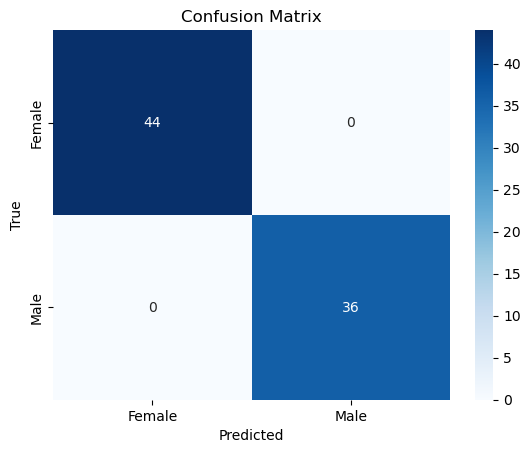

              precision    recall  f1-score   support

      Female       1.00      1.00      1.00        44
        Male       1.00      1.00      1.00        36

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Female', 'Male']))


**Plot MFCCs**

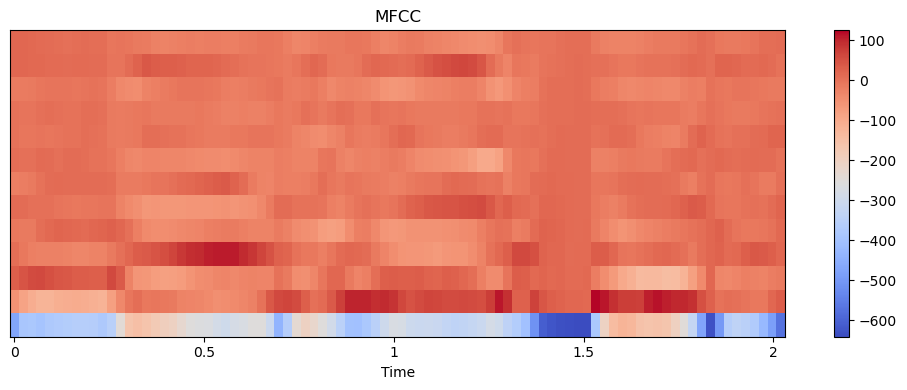

In [17]:
import librosa.display
import matplotlib.pyplot as plt

audio_path = r"C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_angry\YAF_back_angry.wav"
y, sr = librosa.load(audio_path)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


**Chroma Features:**


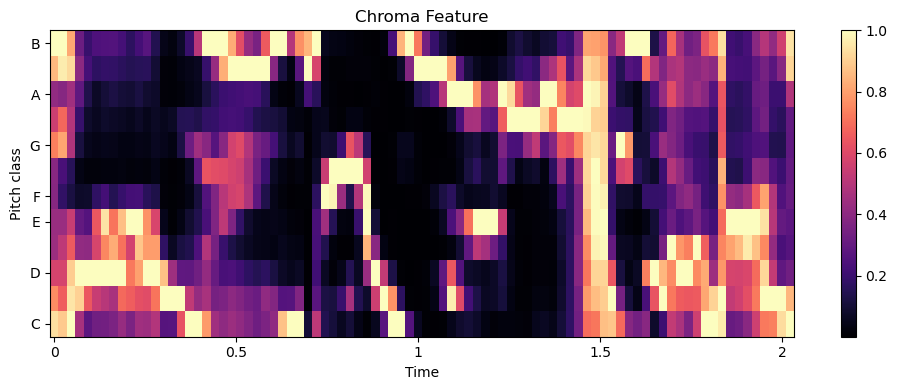

In [18]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma Feature')
plt.tight_layout()
plt.show()


**Spectrogram**

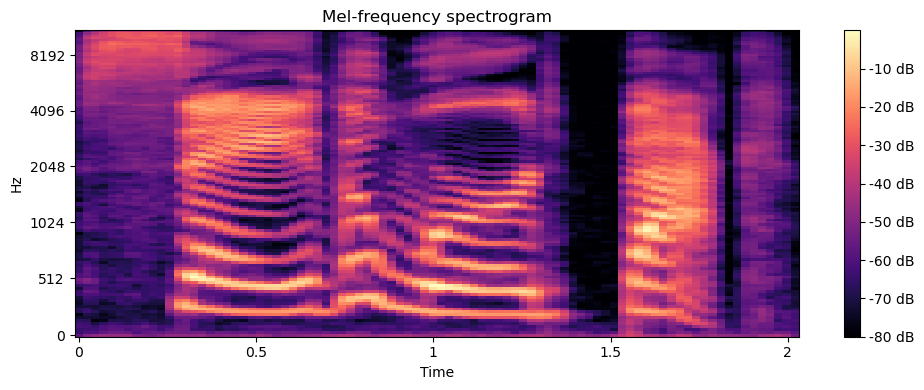

In [19]:
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


## Emotion detection model

In [23]:
import os
import librosa
import numpy as np
import pandas as pd

# Path to the folder containing the audio files
dataset_path = r"C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female"

# Create a list to store the features and labels
features = []
labels = []

# Loop through each emotion folder (e.g., angry, happy, etc.)
for emotion in os.listdir(dataset_path):
    emotion_folder = os.path.join(dataset_path, emotion)
    
    # Ensure the folder is a directory
    if os.path.isdir(emotion_folder):
        for audio_file in os.listdir(emotion_folder):
            audio_path = os.path.join(emotion_folder, audio_file)
            
            # Load the audio file using librosa
            try:
                y, sr = librosa.load(audio_path, sr=None)  # Load the audio file
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract MFCC features
                
                # Calculate the mean of the MFCC features for each audio file
                mfcc_mean = np.mean(mfcc, axis=1)
                
                # Append the features and the emotion label
                features.append(mfcc_mean)
                labels.append(emotion)  # The emotion is the folder name
            except Exception as e:
                print(f"Error processing {audio_path}: {e}")

# Convert the features and labels into a DataFrame
features = np.array(features)
labels = np.array(labels)

# Create a DataFrame for better visualization
df = pd.DataFrame(features)
df['Emotion'] = labels

# Save to CSV for later use
df.to_csv("emotion_features.csv", index=False)

print(f"Dataframe with features and labels has been saved to 'emotion_features.csv'")
print(f"Shape of features: {features.shape}")
print(f"Labels: {set(labels)}")


Dataframe with features and labels has been saved to 'emotion_features.csv'
Shape of features: (1400, 13)
Labels: {'YAF_fear', 'YAF_disgust', 'YAF_happy', 'YAF_neutral', 'YAF_pleasant_surprised', 'YAF_angry', 'YAF_sad'}


In [25]:
from sklearn.model_selection import train_test_split

# Load the data (features and labels)
X = df.drop('Emotion', axis=1).values  # Features (MFCCs)
y = df['Emotion'].values  # Labels (Emotions)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (1120, 13)
Test set shape: (280, 13)


## Training emotion model

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict the emotions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                        precision    recall  f1-score   support

             YAF_angry       0.94      0.91      0.93        35
           YAF_disgust       0.91      0.98      0.94        42
              YAF_fear       0.95      0.93      0.94        42
             YAF_happy       0.93      0.95      0.94        43
           YAF_neutral       1.00      0.91      0.95        46
YAF_pleasant_surprised       0.95      0.95      0.95        40
               YAF_sad       0.94      1.00      0.97        32

              accuracy                           0.95       280
             macro avg       0.95      0.95      0.95       280
          weighted avg       0.95      0.95      0.95       280



## Saving both models

In [28]:
import joblib

# Save the model to a file
joblib.dump(clf, 'emotion_detection_model.pkl')


['emotion_detection_model.pkl']

## Testing emotion & gender of a random file

In [42]:
import os
import numpy as np
import librosa

def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_scaled = np.mean(mfcc.T, axis=0)
    return mfcc_scaled


In [44]:
# Example audio paths (replace with all your audio paths)
female_audio_paths = [
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_angry\YAF_back_angry.wav',
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_disgust\YAF_back_disgust.wav'
]
male_audio_paths = [
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Male\OAF_angry\OAF_back_angry.wav',
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Male\OAF_disgust\OAF_back_disgust.wav'
]

X = []
y_gender = []
y_emotion = []

for path in female_audio_paths:
    X.append(extract_features(path))
    y_gender.append(0)         # Female
    y_emotion.append("angry")  # Dummy emotion, replace appropriately

for path in male_audio_paths:
    X.append(extract_features(path))
    y_gender.append(1)         # Male
    y_emotion.append("disgust")  # Dummy emotion


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

X = np.array(X)

# Gender model
X_train, X_test, y_train, y_test = train_test_split(X, y_gender, test_size=0.2)
gender_model = RandomForestClassifier()
gender_model.fit(X_train, y_train)
joblib.dump(gender_model, 'gender_model.joblib')

# Emotion model (Only using female samples for training)
X_female = X[:len(female_audio_paths)]
y_emotion_female = y_emotion[:len(female_audio_paths)]

emotion_model = RandomForestClassifier()
emotion_model.fit(X_female, y_emotion_female)
joblib.dump(emotion_model, 'emotion_model.joblib')


['emotion_model.joblib']

In [46]:
import os
import numpy as np
import librosa
from sklearn.ensemble import RandomForestClassifier
import joblib

# Paths to your audio samples
female_audio_paths = [
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_angry\YAF_back_angry.wav',
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_disgust\YAF_back_disgust.wav'
]

male_audio_paths = [
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Male\OAF_angry\OAF_back_angry.wav',
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Male\OAF_disgust\OAF_back_disgust.wav'
]

# Feature extraction using MFCCs
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_scaled = np.mean(mfcc.T, axis=0)
    return mfcc_scaled

# Prepare training data
X = []
y = []

for path in female_audio_paths:
    X.append(extract_features(path))
    y.append(0)  # 0 for Female

for path in male_audio_paths:
    X.append(extract_features(path))
    y.append(1)  # 1 for Male

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train Random Forest for gender classification
gender_model = RandomForestClassifier()
gender_model.fit(X, y)

# Save the model
joblib.dump(gender_model, 'gender_model.joblib')
print("✅ gender_model.joblib saved successfully.")


✅ gender_model.joblib saved successfully.


In [47]:
import os
import numpy as np
import joblib
import random
import librosa

# Load models
gender_model = joblib.load('gender_model.joblib')
emotion_model = joblib.load('emotion_model.joblib')

# Dummy feature extraction (same logic used while training)
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_scaled = np.mean(mfcc.T, axis=0)
    return mfcc_scaled

# Sample test files (feel free to add more)
female_audios = [
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_angry\YAF_back_angry.wav',
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_disgust\YAF_back_disgust.wav'
]
male_audios = [
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Male\OAF_angry\OAF_back_angry.wav',
    r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Male\OAF_disgust\OAF_back_disgust.wav'
]

# Classification function
def classify_audio(file_path):
    features = extract_features(file_path).reshape(1, -1)
    gender = gender_model.predict(features)[0]
    
    if gender == 1:
        return "🧔 Male voice detected. Emotion detection not performed."
    else:
        emotion = emotion_model.predict(features)[0]
        return f"👩 Female voice detected. Emotion: {emotion}"

# Run test
test_audio = random.choice(female_audios + male_audios)
print(f"🎧 Testing with audio: {test_audio}")
result = classify_audio(test_audio)
print(f"🔍 Result: {result}")


🎧 Testing with audio: C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female\YAF_disgust\YAF_back_disgust.wav
🔍 Result: 👩 Female voice detected. Emotion: angry


In [49]:
import os
import librosa
import numpy as np
import pandas as pd

# Folder path to TESS/Female
dataset_path = r'C:\Users\Lutifah\Desktop\Speech-emotion-detection-main\TESS\Female'
emotions = os.listdir(dataset_path)

features = []
labels = []

for emotion_folder in emotions:
    emotion_label = emotion_folder.split('_')[-1].lower()  # e.g., 'angry', 'happy'
    files = os.listdir(os.path.join(dataset_path, emotion_folder))
    
    for file in files:
        file_path = os.path.join(dataset_path, emotion_folder, file)
        try:
            audio, sr = librosa.load(file_path)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=32)
            mfccs_mean = np.mean(mfccs.T, axis=0)
            features.append(mfccs_mean)
            labels.append(emotion_label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib

X = np.array(features)
y = np.array(labels)

# Encode emotion labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train
emotion_model = RandomForestClassifier()
emotion_model.fit(X_train, y_train)

# Evaluate
y_pred = emotion_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Save model and label encoder
joblib.dump(emotion_model, 'emotion_model.joblib')
joblib.dump(encoder, 'emotion_label_encoder.joblib')


              precision    recall  f1-score   support

       angry       0.97      0.97      0.97        35
     disgust       0.98      1.00      0.99        42
        fear       1.00      1.00      1.00        42
       happy       0.98      0.95      0.96        43
     neutral       1.00      1.00      1.00        46
         sad       1.00      1.00      1.00        32
   surprised       1.00      1.00      1.00        40

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280



['emotion_label_encoder.joblib']

In [51]:
# Load models
emotion_model = joblib.load('emotion_model.joblib')
emotion_label_encoder = joblib.load('emotion_label_encoder.joblib')
